<a href="https://colab.research.google.com/github/iamfaham/movies-genre-classification/blob/main/IMDB_Genre_Prediction_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# reading the dataset
import json
import pandas as pd
df = pd.read_json("tmdb_movies_combined.json")
df.head()

,id,title,overview,poster_url,primary_genre
0,9355,Mad Max Beyond Thunderdome,Mad Max becomes a pawn in a decadent oasis of ...,https://image.tmdb.org/t/p/w500/jJlxcEVVUHnrUe...,Action
1,707,A View to a Kill,A newly-developed microchip designed by Zorin ...,https://image.tmdb.org/t/p/w500/arJF829RP9cYvh...,Others
2,1369,Rambo: First Blood Part II,John Rambo is released from prison by the gove...,https://image.tmdb.org/t/p/w500/pzPdwOitmTleVE...,Action
3,9846,To Live and Die in L.A.,When his longtime partner on the force is kill...,https://image.tmdb.org/t/p/w500/2iW3pSihBIhXjn...,Others
4,9056,Police Story,Officer Chan Ka Kui manages to put a major Hon...,https://image.tmdb.org/t/p/w500/q8YfsyX59OmoSD...,Action


In [2]:
# checking for dataset shape
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])
# looking for redundant records
print("Number of duplicate records:", int(df.duplicated(keep = "first").sum()))

Number of rows:  103212
Number of columns:  5
Number of duplicate records: 0


In [3]:
# dropping duplicate records
df.drop_duplicates(keep = "first", inplace = True)
df.head()

,id,title,overview,poster_url,primary_genre
0,9355,Mad Max Beyond Thunderdome,Mad Max becomes a pawn in a decadent oasis of ...,https://image.tmdb.org/t/p/w500/jJlxcEVVUHnrUe...,Action
1,707,A View to a Kill,A newly-developed microchip designed by Zorin ...,https://image.tmdb.org/t/p/w500/arJF829RP9cYvh...,Others
2,1369,Rambo: First Blood Part II,John Rambo is released from prison by the gove...,https://image.tmdb.org/t/p/w500/pzPdwOitmTleVE...,Action
3,9846,To Live and Die in L.A.,When his longtime partner on the force is kill...,https://image.tmdb.org/t/p/w500/2iW3pSihBIhXjn...,Others
4,9056,Police Story,Officer Chan Ka Kui manages to put a major Hon...,https://image.tmdb.org/t/p/w500/q8YfsyX59OmoSD...,Action


<Axes: >

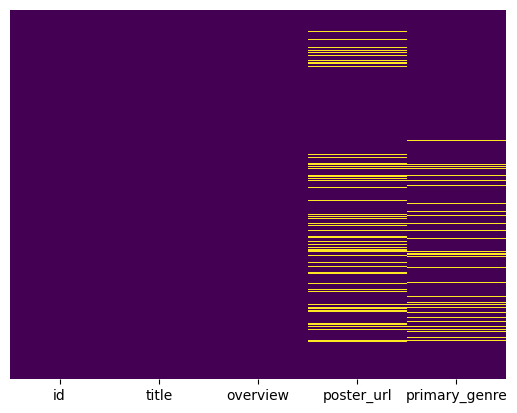

In [4]:
# checking for missing values
import seaborn as sns
sns.heatmap(df.isna(), cbar = False, yticklabels = False, cmap = "viridis")

In [5]:
# removing missing values
df.dropna(inplace = True)
df.head(3)

,id,title,overview,poster_url,primary_genre
0,9355,Mad Max Beyond Thunderdome,Mad Max becomes a pawn in a decadent oasis of ...,https://image.tmdb.org/t/p/w500/jJlxcEVVUHnrUe...,Action
1,707,A View to a Kill,A newly-developed microchip designed by Zorin ...,https://image.tmdb.org/t/p/w500/arJF829RP9cYvh...,Others
2,1369,Rambo: First Blood Part II,John Rambo is released from prison by the gove...,https://image.tmdb.org/t/p/w500/pzPdwOitmTleVE...,Action


Value Counts:
 primary_genre
Others         18469
Drama          15033
Comedy         10306
Documentary     9762
Action          9754
Horror          8984
Animation       8570
Name: count, dtype: int64


<Axes: xlabel='primary_genre'>

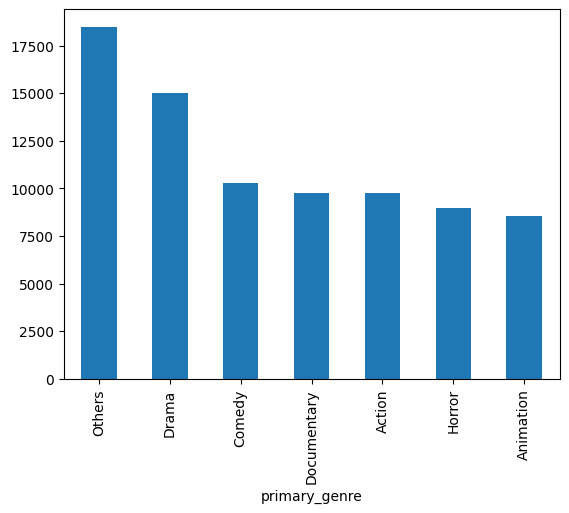

In [6]:
# checking for value counts in primary_genre
print("Value Counts:\n", df["primary_genre"].value_counts())
df["primary_genre"].value_counts().plot(kind = "bar")

In [7]:
# 🔴 Drop the "others" genre and rebuild X, y
# ------------------------------------------------
# 1. Keep rows whose primary_genre is NOT "others"
mask = ~df["primary_genre"].str.lower().eq("others")
df   = df.loc[mask].reset_index(drop=True)

# 2. Re-create feature matrix or embedding arrays
#    (replace `make_features(df)` with your own feature-building call)
# X = make_features(df)          # e.g. concatenated text & image embeddings
# y = df["primary_genre"].values # target labels now have no "others"
print(f"New dataset size : {len(df):,} movies")
# print("Remaining genres  :", pd.Series(y).unique())


New dataset size : 62,409 movies


<Axes: xlabel='primary_genre'>

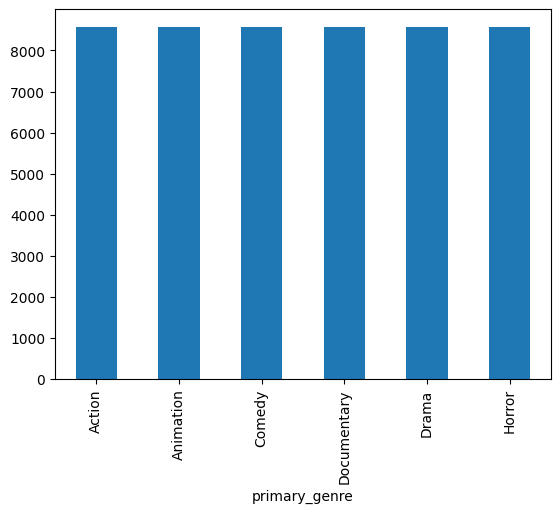

In [8]:
# performing random undersampling
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
newDf, target = undersampler.fit_resample(df.drop("primary_genre", axis = 1), df["primary_genre"])
df = pd.concat([newDf, target], axis = 1)
df["primary_genre"].value_counts().plot(kind = "bar")

In [9]:
# analyzing description texts
df['overview'].head(3)

,overview
3542,"Dinesh, who is jilted by Laxmi's rejection, pl..."
5666,A gang of four eyed crooks led by Kurt Bishop ...
29533,A sheriff investigates why the guests at a loc...


In [10]:
# setting up NLTK
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()

def cleanText(text: str):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator).lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [12]:
df["overview"] = df["overview"].apply(cleanText)

,overview
count,51420.000000
mean,26.357079
std,19.279256
min,0.000000
25%,13.000000
50%,21.000000
75%,36.000000
max,162.000000


[Text(0.5, 1.0, 'Distribution of Token Counts of Descriptions')]

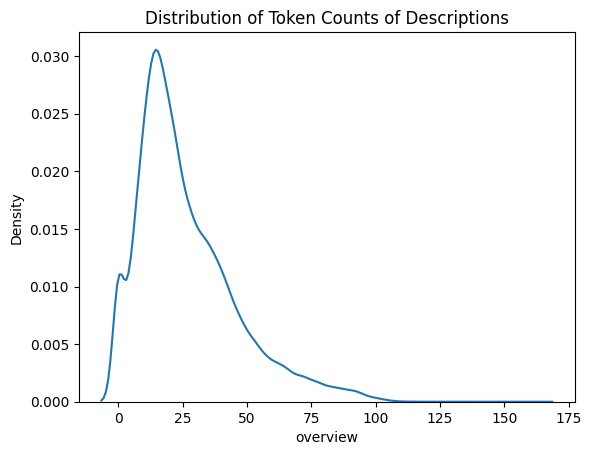

In [13]:
# checking for distribution of word tokens present in the descriptions
tokenCounts = df["overview"].apply(lambda x: len(nltk.word_tokenize(text = x)))
display(tokenCounts.describe())
display(sns.kdeplot(x = tokenCounts).set(title = "Distribution of Token Counts of Descriptions"))

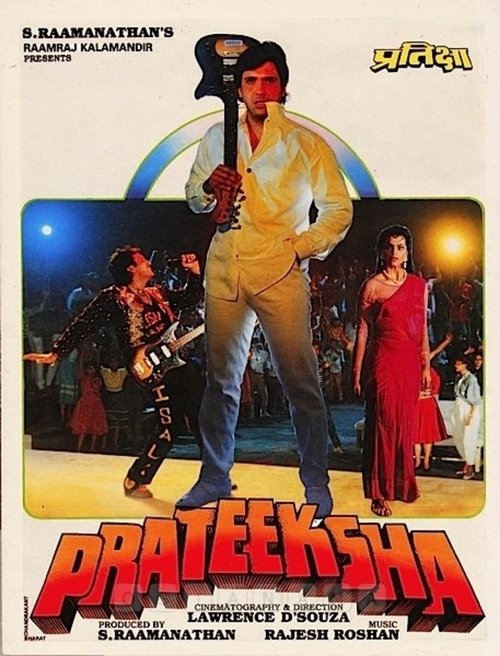

In [14]:
# checking for a sample image
import requests
from PIL import Image
import io
Image.open(io.BytesIO(requests.get(df["poster_url"].iloc[0]).content))

In [15]:
df.head()


,id,title,overview,poster_url,primary_genre
3542,827770,Prateeksha,dinesh jilted laxmis rejection plot revenge fr...,https://image.tmdb.org/t/p/w500/nWm6qh4DD1p3A0...,Action
5666,41366,New World Disorder,gang four eyed crook led kurt bishop ripping t...,https://image.tmdb.org/t/p/w500/im2ABD5QikhnDH...,Action
29533,5730,Inn of the Damned,sheriff investigates guest local hostelry chec...,https://image.tmdb.org/t/p/w500/cw994RGIwFW58L...,Action
16339,256092,Drive Hard,former race car driver abducted mysterious thi...,https://image.tmdb.org/t/p/w500/wSujXhZJPvwKtM...,Action
4926,57831,The Apocalypse,salvage pilot bartender go crazed computer pro...,https://image.tmdb.org/t/p/w500/tgYvEEiKKLpMy1...,Action


In [16]:
# ▸▸ Poster dataloader (streams ≤BATCH_SIZE images at a time) ◂◂
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import requests, io, torch, gc
from torchvision import transforms


DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
IMG_BATCH   = 32                       # drop to 16 if you still OOM

# class PosterDS(Dataset):
#     def __init__(self, urls):
#         self.urls = urls                # just the strings, tiny in RAM

#     def __len__(self):  return len(self.urls)

#     def __getitem__(self, idx):
#         url = self.urls[idx]
#         try:
#             img_bytes = requests.get(url, timeout=5).content
#             img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
#             return img
#         except Exception:
#             return None                 # let collate_fn skip bad images


class PosterDS(torch.utils.data.Dataset):
    def __init__(self, urls, transform =None):
        self.urls      = urls
        self.transform = transform

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        url = self.urls[idx]
        try:
            img = Image.open(requests.get(url, timeout=5).content).convert("RGB")
            img = self.transform(img)
            return idx, img        # ←  (row-index, image-tensor)
        except Exception:
            return None            # signals failure



# def collate_fn(batch):
#     return [img for img in batch if img is not None]

# ⬇︎ define right after the dataset, before DataLoader
def poster_collate(batch):
    batch = [item for item in batch if item is not None]     # drop failures
    if not batch:                                            # whole batch failed
        return torch.empty(0), []                            # imgs, idxs
    idxs, imgs = zip(*batch)                                 # unzip
    imgs = torch.stack(imgs, 0)
    return imgs, idxs


poster_loader = DataLoader(
    # PosterDS(df["poster_url"].tolist(), transform=poster_tf ),
    PosterDS(df["poster_url"].tolist() ),
    batch_size = IMG_BATCH,
    shuffle    = False,
    num_workers=2,
    collate_fn = poster_collate,
    pin_memory = (DEVICE=="cuda")
)


In [17]:
# using mixedbread-ai/mxbai-embed-large-v1 embeddings with embedding dimension as 1024
from sentence_transformers import SentenceTransformer
textEncoderModel = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", truncate_dim = 1024).to("cuda")
# textEmbeddings = textEncoderModel.encode(df["overview"].tolist(), normalize_embeddings=True)
textEmbeddings = textEncoderModel.encode(
    df["overview"].tolist(),
    normalize_embeddings = True,
    batch_size           = 64,          # 32–128 → tune to your GPU
    convert_to_numpy     = True,
    device               = DEVICE
)
torch.cuda.empty_cache(); gc.collect()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/114k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

16

In [ ]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
from tqdm import tqdm
import torch

# setup
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50", trust_remote_code=True)
model = AutoModel.from_pretrained("microsoft/resnet-50", trust_remote_code=True).to("cuda")
model.eval()


embeddings = []
success_idx  = []

with torch.inference_mode():
    for imgs, idxs in tqdm(poster_loader):   # imgs, idxs instead of just imgs
        if not idxs:                         # batch with all failures
            continue

        inputs = processor(images=imgs, return_tensors="pt").to(DEVICE)
        feats  = model(**inputs).last_hidden_state[:, 0]      # (B, 2048)

        embeddings.append(feats.cpu())
        success_idx.extend(idxs)              # record true dataframe rows
imageEmbeddings = torch.cat(embeddings, dim=0).numpy()             # (≈60 000, 2048)
gc.collect()



preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

 95%|█████████▌| 1529/1607 [45:31<01:54,  1.47s/it]

In [ ]:
feat_dim = imageEmbeddings.shape[1]
imageEmbeddings_full = np.zeros((len(df), feat_dim), dtype=imageEmbeddings.dtype)
imageEmbeddings_full[np.array(success_idx)] = imageEmbeddings
imageEmbeddings = imageEmbeddings_full

In [ ]:
imageEmbeddings.shape

In [ ]:
print("imageEmbeddings shape:", imageEmbeddings.shape)   # expect (60000, 2048)
print("textEmbeddings  shape:", textEmbeddings.shape)    # expect (60000, 768)


In [ ]:
# ── Create y from your dataframe ───────────────────────────────────────
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["genre_id"] = le.fit_transform(df["primary_genre"])   # add new int column
y = df["genre_id"].values                                # 1-D numpy array

print("y shape:", y.shape)
print("class ↦ id mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


In [ ]:
# === TEXT-ONLY LSTM CLASSIFIER =========================================
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def train_lstm_text(X_text, y, epochs=15, hidden=256, batch=128, lr=1e-3):
    """
    X_text : np.ndarray  (N, seq_len, embed_dim)  OR  (N, embed_dim)
             If 2-D, we treat each vector as a sequence of length 1.
    y      : np.ndarray  integer labels
    """
    # Ensure 3-D: (N, seq_len, embed_dim)
    if X_text.ndim == 2:
        X_text = X_text[:, None, :]
    seq_len, embed_dim = X_text.shape[1], X_text.shape[2]
    n_classes          = int(y.max() + 1)

    Xtr, Xval, ytr, yval = train_test_split(
        X_text, y, test_size=0.2, random_state=42, stratify=y
    )

    ds_tr  = TensorDataset(torch.tensor(Xtr, dtype=torch.float32),
                           torch.tensor(ytr, dtype=torch.long))
    ds_val = TensorDataset(torch.tensor(Xval, dtype=torch.float32),
                           torch.tensor(yval, dtype=torch.long))
    dl_tr  = DataLoader(ds_tr,  batch_size=batch, shuffle=True)
    dl_val = DataLoader(ds_val, batch_size=batch)

    class TextLSTM(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm  = nn.LSTM(embed_dim, hidden, num_layers=2,
                                 batch_first=True, dropout=0.3, bidirectional=False)
            self.fc    = nn.Linear(hidden, n_classes)
        def forward(self, x):
            _, (h_n, _) = self.lstm(x)           # h_n shape: (num_layers, B, hidden)
            out = self.fc(h_n[-1])               # use last layer’s hidden state
            return out

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = TextLSTM().to(device)
    opt    = torch.optim.AdamW(model.parameters(), lr=lr)
    crit   = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        for xb, yb in dl_tr:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
        if epoch % 5 == 0 or epoch == epochs:
            model.eval()
            all_pred, all_true = [], []
            with torch.no_grad():
                for xb, yb in dl_val:
                    xb = xb.to(device)
                    pred = model(xb).argmax(1).cpu()
                    all_pred.extend(pred)
                    all_true.extend(yb)
            print(f"[Epoch {epoch}] val acc = "
                  f"{(torch.tensor(all_pred) == torch.tensor(all_true)).float().mean():.4f}")

    print("\nTEXT-ONLY LSTM – validation report")
    print(classification_report(all_true, all_pred))
    return model

lstm_text_model = train_lstm_text(textEmbeddings, y)


In [ ]:
# === IMAGE-ONLY MLP CLASSIFIER =========================================
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def train_mlp_image(X_img, y, epochs=20, batch=256, lr=1e-3):
    """
    X_img : np.ndarray  (N, embed_dim)
    y     : np.ndarray  integer labels
    """
    in_dim       = X_img.shape[1]
    n_classes    = int(y.max() + 1)

    Xtr, Xval, ytr, yval = train_test_split(
        X_img, y, test_size=0.2, random_state=42, stratify=y
    )

    ds_tr  = TensorDataset(torch.tensor(Xtr, dtype=torch.float32),
                           torch.tensor(ytr, dtype=torch.long))
    ds_val = TensorDataset(torch.tensor(Xval, dtype=torch.float32),
                           torch.tensor(yval, dtype=torch.long))
    dl_tr  = DataLoader(ds_tr,  batch_size=batch, shuffle=True)
    dl_val = DataLoader(ds_val, batch_size=batch)

    class ImageMLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, n_classes)
            )
        def forward(self, x): return self.net(x)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = ImageMLP().to(device)
    opt    = torch.optim.AdamW(model.parameters(), lr=lr)
    crit   = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        for xb, yb in dl_tr:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
        if epoch % 5 == 0 or epoch == epochs:
            model.eval()
            all_pred, all_true = [], []
            with torch.no_grad():
                for xb, yb in dl_val:
                    xb = xb.to(device)
                    pred = model(xb).argmax(1).cpu()
                    all_pred.extend(pred)
                    all_true.extend(yb)
            print(f"[Epoch {epoch}] val acc = "
                  f"{(torch.tensor(all_pred) == torch.tensor(all_true)).float().mean():.4f}")

    print("\nIMAGE-ONLY MLP – validation report")
    print(classification_report(all_true, all_pred))
    return model

mlp_image_model = train_mlp_image(imageEmbeddings, y)


In [ ]:
# Convert (59990, 7, 7)  →  (59990, 49)
# imageEmbeddings = imageEmbeddings.reshape(imageEmbeddings.shape[0], -1)
print("Flattened imageEmbeddings:", imageEmbeddings.shape)   # (59990, 49)


In [ ]:
# Should be >0 if real embeddings are present
non_zero_rows = np.count_nonzero(np.linalg.norm(imageEmbeddings, axis=1) > 0)
print("Rows with real poster features:", non_zero_rows)    # probably prints 0 right now


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Input: Choose your feature set ===
# X = textEmbeddings  # or imageEmbeddings or fused
# GOOD: row-wise concatenation → 2-D
X = np.concatenate([imageEmbeddings, textEmbeddings], axis=1)   # (60000, 2816)
y = df["primary_genre"].values

# === Optional: PCA (to reduce overfitting in high-dim) ===
use_pca = True
n_components = 256  # Tune this (e.g., 50, 100, 200)

# === Train/Val Split ===
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === Normalize ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# === Apply PCA if needed ===
if use_pca:
    pca = PCA(n_components=n_components, random_state=42)
    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)

# === Logistic Regression with Regularization ===
# C is inverse of regularization: lower C = stronger regularization
clf = LogisticRegression(
    C=0.1,  # try 0.01 or 0.001 for stronger regularization
    max_iter=1000,
    solver='lbfgs',
    multi_class='multinomial'
)
clf.fit(X_train, y_train)

# === Predict ===
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

# === Accuracy ===
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"✅ Train Accuracy: {train_acc:.4f}")
print(f"✅ Validation Accuracy: {val_acc:.4f}")

# === Reports ===
print("\n📊 Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("\n📊 Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

# === Confusion Matrix ===
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Validation Confusion Matrix")
plt.show()


In [ ]:
# stacking images and text embeddings horizontally
embeddings = np.hstack((imageEmbeddings, textEmbeddings))

In [ ]:
# encoding the target feature
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# df["primary_genre"] = encoder.fit_transform(df["primary_genre"])

In [ ]:
# using a train-test-split for confusion matrix
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(embeddings, df["primary_genre"], test_size=0.20, random_state=10)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score

poly_lr = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),  # cubic terms & interactions
    StandardScaler(with_mean=False),                  # keep sparse matrix compact
    LogisticRegression(
        penalty="l2",
        C=1.0,
        max_iter=200,
        multi_class="multinomial",
        n_jobs=-1,
        class_weight="balanced"
    )
)

poly_lr.fit(x_train, y_train)
y_pred = poly_lr.predict(X_val)
print("Poly-LR val accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred, digits=3))


In [ ]:
# ── Encode primary_genre strings → 0 … num_classes-1  ──
# from sklearn.preprocessing import LabelEncoder
# import pandas as pd, gc

# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(df["primary_genre"])   # numpy int64 array
# print("Unique genres:", list(label_encoder.classes_))  # optional

# # keep a DataFrame column if you need it later
# df["genre_id"] = y
# gc.collect()


In [ ]:
# ---- Sanity-check & repair the genre labels ----
import numpy as np, torch, gc

# y is the numpy / pandas column you just created
num_classes = len(np.unique(y))
print("Detected #genres:", num_classes)

# 1. make sure labels start at 0 and are consecutive
y_min, y_max = y.min(), y.max()
assert y_min >= 0, f"Found negative label ({y_min})"
assert y_max < num_classes, f"Label {y_max} ≥ num_classes-1 ({num_classes-1})"

# 2. cast to int64 (PyTorch 'long')
y = y.astype("int64")
gc.collect()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Convert to tensors (if not already done earlier)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# PyTorch Logistic Regression Model
class PyTorchLogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(PyTorchLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=1)

num_classes = len(np.unique(y_train))      # y_train is the 1-D int64 array
print("Num classes:", num_classes)         # → should print 7


# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logreg_model = PyTorchLogisticRegression(x_train.shape[1], num_classes).to(device)
optimizer = torch.optim.Adam(logreg_model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.NLLLoss()

# Training loop
train_accuracies = []
val_accuracies = []

best_val_acc = 0
patience = 3
wait = 0

for epoch in range(20):  # Increased epochs
    logreg_model.train()
    total_loss = 0
    correct = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = logreg_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (preds.argmax(dim=1) == yb).sum().item()

    train_acc = correct / len(train_loader.dataset)
    train_accuracies.append(train_acc)

    # Validation accuracy
    logreg_model.eval()
    correct = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = logreg_model(xb)
            correct += (preds.argmax(dim=1) == yb).sum().item()
    val_acc = correct / len(test_loader.dataset)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluation
logreg_model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds = logreg_model(xb)
        all_preds.append(preds.cpu().numpy())

predicted = np.argmax(np.vstack(all_preds), axis=1)

# 💡 Make sure we tell sklearn the label order
cm = confusion_matrix(y_test, predicted, labels=range(len(encoder.classes_)))

labels = encoder.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.tight_layout()
plt.show()

In [ ]:
print("Unique y_test values:", np.unique(y_test))
print("Encoder classes:", encoder.classes_)


In [ ]:
# standardizing the inputs
# Convert to torch tensors first
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# Compute mean and std from training data
mean = x_train_tensor.mean(dim=0, keepdim=True)
std = x_train_tensor.std(dim=0, keepdim=True)

# Avoid division by zero
std[std == 0] = 1

# Normalize
x_train_tensor = (x_train_tensor - mean) / std
x_test_tensor = (x_test_tensor - mean) / std

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Convert data to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Define the PyTorch ANN model
class GenreClassifier(nn.Module):
    def __init__(self, input_dim):
        super(GenreClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.3)

        self.output = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        return F.log_softmax(self.output(x), dim=1)


# Instantiate and train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GenreClassifier(x_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.NLLLoss()

train_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0
patience = 5
wait = 0

for epoch in range(50):
    model.train()
    total_loss = 0
    correct = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (preds.argmax(dim=1) == yb).sum().item()

    train_acc = correct / len(train_loader.dataset)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            correct += (preds.argmax(dim=1) == yb).sum().item()

    val_acc = correct / len(test_loader.dataset)
    val_accuracies.append(val_acc)
    train_losses.append(total_loss)

    print(f"Epoch {epoch+1:2d} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹ Early stopping triggered.")
            break


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ANN Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss over epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for test set
model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())

predicted = np.argmax(np.vstack(all_preds), axis=1)
cm = confusion_matrix(y_test, predicted)

labels = le.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (ANN)")
plt.tight_layout()
plt.show()


In [ ]:
model.eval()
correct = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        correct += (preds.argmax(dim=1) == yb).sum().item()

final_acc = correct / len(test_loader.dataset)
print(f"Final Test Accuracy: {final_acc:.4f}")
